# <center>Gold price prediction</center>

Gold price variation can be sensitive to many features such as global economy, international tension, epidemic or global pandemic, and so on. Many efforts have been done by other scientists and researchers regarding this topic [1-7]. In this project, we are going to analysis the gold price data, and try to predict future gold prices, by exploring features which affect the price of gold more significantly. The goal of this project is to create a profitable model for gold price prediction. The key of this project is, we can never let the model see any "future" data when applying on the test data to evaluate the model performance. 

## 1. Data Collection, Wrangling, and Exploratory Analysis for Gold Prices

Historical gold price data were obtained from COMEX Delayed Price Gold Feb 21 (GC=F), Currency in USD at finance.yahoo.com [8].

In [1]:
import ylearn as yl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle

We firstly downloaded the data, then we selected open price as dependent variable for prediction.

In [2]:
gold0=yl.yahoo_finance('GC=F', start_date='2000-08-30')

In [3]:
##########################
# Delete Missing values
##########################
gold=gold0.dropna()
yl.missing_value_report(gold0)

,Value
Original number of rows,5312
Final number of rows,5200
Number of rows with NaN,112
NaN rate,2.11%


We focus on open prices as dependent variable, and subset the open column.

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


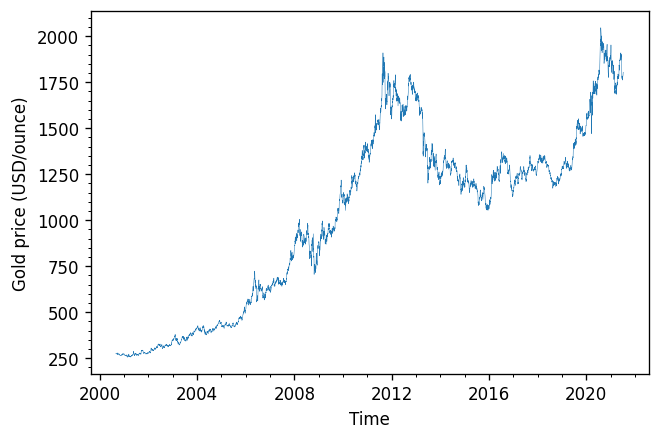

In [4]:
_=yl.plot_gold(gold['open'])

Now we analyze the characteristic properties of the gold price time series data. Is the price of gold random walk and totally non-predictable? We will analyze the trend, periodicity (seasonality), and autocorrelation of the data set, and test a way to make the data set stationary. 

In [5]:
#####################################################
# Test whether gold price time series is random walk
#####################################################
yl.adfuller_report(gold['open'].diff().dropna())

,Value
ADF Statistic:,-18.544
p-value:,0.000000000
Critical Values 1%:,-3.432
Critical Values 5%:,-2.862
Critical Values 10%:,-2.567


With an extremely small p-value from an Augmented Dickey-Fuller test on the first order difference of the gold price time series, we can reject the null hypothesis of random walk, and conclude that the time series is not a random walk. It is possible to predict the gold price!

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


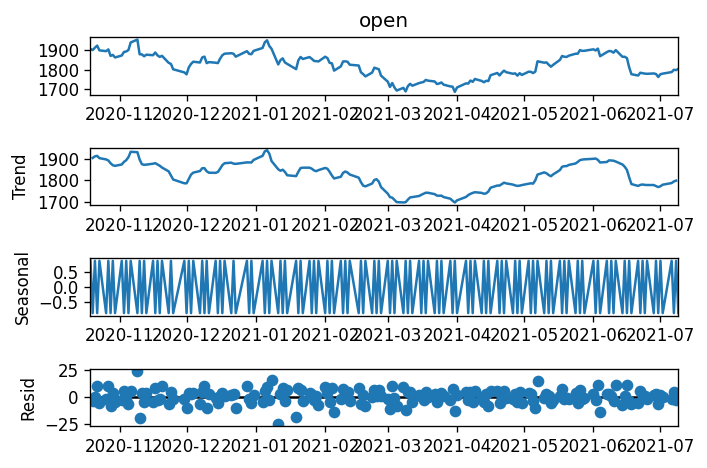

In [6]:
#####################################################################
# Decompose the gold price time series for the most recent half year
#####################################################################
_=yl.seasonal_decompose_plot(gold['open'].iloc[-180:], model='linear', period=2)

It seems that the gold price has a seasonal component. It may due to a mean reversion: when the price gets higher, people want to sell, causing the price go lower, and then people want to buy, causing the price higher, again and again. 

It is possible to use the mean reversion to make the model profitable (to make prediction by the behavior of gold price itself), but I won't stop at that stage. This project is focusing on exogenous variables on gold prices and make a regression as precise as possible. The model will be able to predict the future gold prices in a considerable time windows (several days to a week).

In [7]:
#########################################################
# Use kpss to tell if apple stock return is stationary
#########################################################
pd.DataFrame({' ': ['p-value'], 
             '1 order of difference': [kpss(gold['open'].diff().dropna())[1]]}).set_index(' ').T

,p-value
1 order of difference,0.1


It turns out the gold return is stationary.

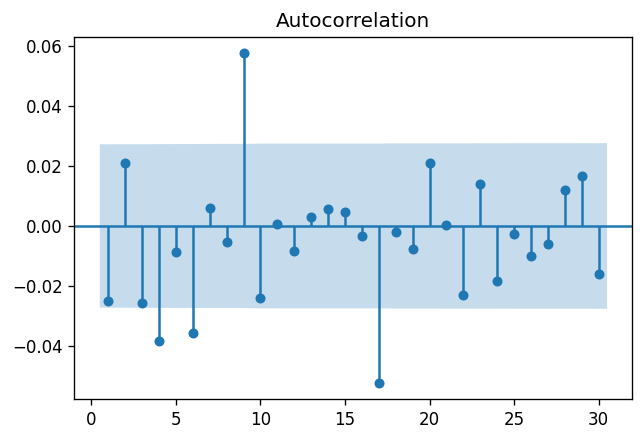

In [8]:
###################################################################################################################
# Autocorrelation investigation for gold price time series (95% confidence interval)
###################################################################################################################
_=plot_acf(gold['open'].diff().dropna(), lags=30, zero=False, alpha=0.05)
plt.show()

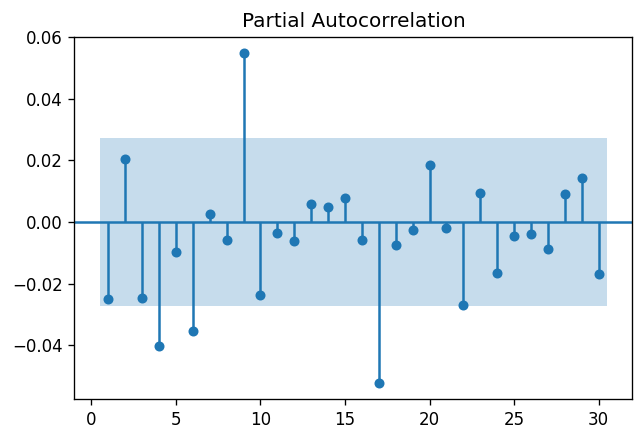

In [9]:
_=plot_pacf(gold['open'].diff().dropna(), lags=30, zero=False, alpha=0.05)
plt.show()

The first order difference (gold price return) makes the time series stationary, that makes $d$=1. However, it is not conclusive that which AR or MA model can fit the time series from the ACF and PACF plot. I am going to use hyperparameter tunning to find out.

## 2. Baseline Model: No Exogenous Variables

### 2.1 SARIMAX approach

Next I am going to use an Autoregressive Integrated Moving Averages (ARIMA) model to fit and predict the gold prices. ARIMA is well-known for forecasting stocks and financial market fluctuations, and data scientists and researchers have been utilizing ARIMA model to predict the price of gold [1,6]. Without helps of exogenous variables, I will find out how good our prediction will be.

In my other projects, I found that if I predict gold or stock prices once a week, the prediction results are pretty good. However, making predictions once a week is not aggresive enough to make the model profitable. In this project, I am going to try a pattern of predicting three times per week. 

Note that for the time series machine learning practices, I have to pay attention that the model can never see any "future" data. In other words, "future" data cannot leak to the model. That is the key for the precision of the model.

Another thing is, if I consider using the whole data set, the early gold price is not in the same scale because of inflation and among other reasons. Machine learning models might misunderstanding the relatively cheap gold prices in old years. Therefore I only consider using the gold prices after 2018.

In [15]:
#################################
# Take a look at where data ends
#################################
gold[['open']].tail()

,open
Date,
2021-07-02,1778.699951
2021-07-06,1786.699951
2021-07-07,1798.699951
2021-07-08,1797.000000
2021-07-09,1803.599976


In [13]:
#################################################
# Fill missing values for weekends and holidays
#################################################
Y=gold[['open']].loc[pd.to_datetime("2020", format='%Y'):]
Y=Y.resample('D').ffill()
##############################################
# Train test split:
# Train 2020
# Test 2021 to present
##############################################
y_train=Y.loc[Y.index<pd.to_datetime("2021", format='%Y')]
y_test=Y.loc[Y.index>=pd.to_datetime("2021", format='%Y')]

I use root mean squared error (RMSE) and precision for price rising as metrics for optimization. I want the predicted price number to be close to the real number, also more importantly I want the call about the price rising to be right. The unit of RMSE is also dollar ($). This is going to be my baseline model.   

In [23]:
random.seed(3)
params=list(set([(
    random.sample([1, 2, 3], 1)[0], random.sample([1, 2, 3], 1)[0], 
    random.sample([1, 2, 3], 1)[0], random.sample([0, 1, 2, 3], 1)[0], 
    random.sample([0, 1, 2, 3], 1)[0], random.sample([0, 1, 2, 3], 1)[0],
    random.sample([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 1)[0]) for i in range(1000)]))
len(params)

984

In [ ]:
#########################################################################
# No exogenous variables - baseline
# Do hyperparameter tunning using 5-fold cross validation
#########################################################################
results=yl.sarimax_cross_validation(y_train, cv=5, params=params)
results.head()

 89%|████████▉ | 877/984 [51:51:21<5:52:11, 197.49s/it]   

In [ ]:
test_results=yl.select_best_sarimax_model(results, y_train, y_test, top=50)
test_results.head()

In [11]:
sarimax_params_baseline=(1, 3, 1, 1, 2, 1, 15)

Prediction accuracy is 65.00%
-----------------------------------------------------------------------
       True Positive  False Negative  False Positive  True Negative
Count             27              15              13             25
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.66      0.64        38
           1       0.68      0.64      0.66        42

    accuracy                           0.65        80
   macro avg       0.65      0.65      0.65        80
weighted avg       0.65      0.65      0.65        80

-----------------------------------------------------------------------


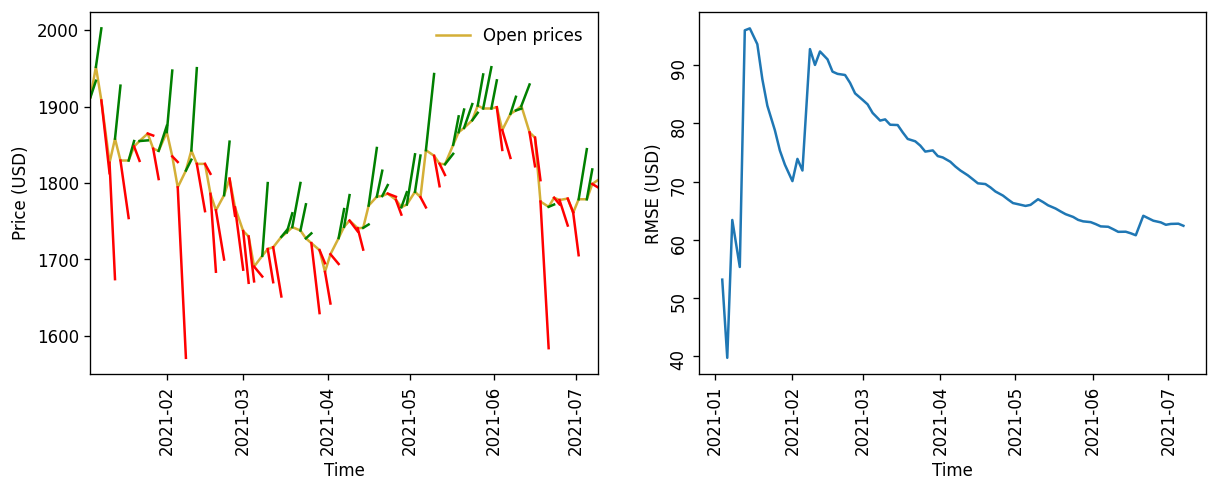

In [14]:
test_prices_sarimax_baseline=yl.display_best_sarimax_model(y_train, y_test, sarimax_params_baseline)

It can be seen that, in an aggressive prediction pattern (three times of prediction per week), the baseline algorithm (SARIMAX) has shown considerable prediction power.

## 3. Exogenous Variables

In the baseline model, I used an aggresive prediction pattern (three times of prediction per week). A SARIMAX model without any exogenous variables shows weak prediction power. Now with the help of exogenous variables, I hope to achieve more prediction power from the model. Support Vector Machines (SVMs) works effectively on high dimension data, so I am using SVMs to investigate the prediction power of exogenous variables on gold prices. 

I will also use neural networks to extract prediction power from exogenous data set. Finally, I am ensembling SARIMAX, SVMs, and neural networks to make the final prediction. 

### 3.1 Exogenous Feature Selection

#### 3.1.1 Silver May 21 (SI=F)

In [16]:
################################################
# Load the exogenous variables:
# Silver May 21 (SI=F)
################################################
ag0=yl.yahoo_finance('SI=F')
ag=ag0.dropna()
yl.missing_value_report(ag0)

,Value
Original number of rows,5312
Final number of rows,5202
Number of rows with NaN,110
NaN rate,2.07%


#### 3.1.2 Platinum Jul 21 (PL=F)

In [17]:
################################################
# Load the exogenous variables:
# Platinum Jul 21 (PL=F)
################################################
pt0=yl.yahoo_finance('PL=F')
pt=pt0.dropna()
yl.missing_value_report(pt0)

,Value
Original number of rows,5483
Final number of rows,4673
Number of rows with NaN,810
NaN rate,14.77%


#### 3.1.3 Crude Oil Jun 21 (CL=F)

In [18]:
################################################
# Load the exogenous variables:
# Crude Oil Jun 21 (CL=F)
################################################
oil0=yl.yahoo_finance('CL=F')
oil=oil0.dropna()
yl.missing_value_report(oil0)

,Value
Original number of rows,5317
Final number of rows,5210
Number of rows with NaN,107
NaN rate,2.01%


#### 3.1.4 US Dollar Jun 21 (DX=F)

In [19]:
################################################
# Load the exogenous variables:
# US Dollar Jun 21 (DX=F)
################################################
dollar0=yl.yahoo_finance('DX=F')
dollar=dollar0.dropna()
yl.missing_value_report(dollar0)

,Value
Original number of rows,5361
Final number of rows,5285
Number of rows with NaN,76
NaN rate,1.42%


#### 3.1.5 S&P 500 (^GSPC)

In [20]:
################################################
# Load the exogenous variables:
#  S&P 500 (^GSPC)
################################################
sp0=yl.yahoo_finance('^GSPC')
sp=sp0.dropna()
yl.missing_value_report(sp0)

,Value
Original number of rows,5414
Final number of rows,5414
Number of rows with NaN,0
NaN rate,0.00%


#### 3.1.6 NASDAQ Composite (^IXIC)

In [21]:
################################################
# Load the exogenous variables:
#  NASDAQ Composite (^IXIC)
################################################
nasdaq0=yl.yahoo_finance('^IXIC')
nasdaq=nasdaq0.dropna()
yl.missing_value_report(nasdaq0)

,Value
Original number of rows,5414
Final number of rows,5414
Number of rows with NaN,0
NaN rate,0.00%


#### 3.1.7 CBOE Volatility Index (^VIX)

In [22]:
################################################
# Load the exogenous variables:
#  CBOE Volatility Index (^VIX)
################################################
vix0=yl.yahoo_finance('^VIX')
vix=vix0.dropna()
yl.missing_value_report(vix0)

,Value
Original number of rows,5414
Final number of rows,5414
Number of rows with NaN,0
NaN rate,0.00%


In [23]:
exogenous_list=[ag[['open']], 
                pt[['open']], 
                oil[['open']], 
                dollar[['open']], 
                sp[['open']], 
                nasdaq[['open']], 
                vix[['open']]]

### 3.2 SARIMAX Models with Exogenous Variables

#### 3.2.1 SARIMAX Models with Ag Only

In [58]:
random.seed(6)
params=list(set([(
    random.sample([1, 2, 3], 1)[0], random.sample([1, 2, 3], 1)[0], 
    random.sample([1, 2, 3], 1)[0], random.sample([0, 1, 2, 3], 1)[0], 
    random.sample([0, 1, 2, 3], 1)[0], random.sample([0, 1, 2, 3], 1)[0],
    random.sample([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 1)[0]) for i in range(500)]))
len(params)

495

In [22]:
#########################################################################
# Do hyperparameter tunning using 5-fold cross validation
#########################################################################
results=yl.sarimax_cross_validation(y_train, cv=5, params=params, exogenous=True, exogenous_list=exogenous_list)
results.head()

100%|██████████| 993/993 [124:20:35<00:00, 450.79s/it]    


,params,RMSE list,mean RMSE,accuracy list,mean accuracy
210,"(0, 3, 3, 3, 1, 1, 10)","[81.06, 29.04, 39.58, 21.30, 27.65]",39.725040,"[0.74, 0.46, 0.67, 0.61, 0.71]",0.636232
556,"(3, 1, 0, 2, 2, 3, 15)","[82.56, 40.58, 38.41, 24.34, 28.60]",42.896931,"[0.74, 0.54, 0.58, 0.70, 0.58]",0.628623
495,"(3, 2, 0, 0, 2, 2, 15)","[106.52, 54.38, 59.21, 41.75, 39.86]",60.342578,"[0.70, 0.62, 0.58, 0.61, 0.62]",0.627536
237,"(0, 2, 0, 2, 1, 0, 10)","[111.79, 85.14, 102.63, 58.27, 73.09]",86.183282,"[0.70, 0.50, 0.62, 0.70, 0.58]",0.619928
438,"(3, 3, 0, 3, 1, 0, 14)","[228.31, 119.38, 135.73, 83.58, 92.19]",131.836679,"[0.52, 0.54, 0.67, 0.70, 0.67]",0.618478


In [23]:
test_results=yl.select_best_sarimax_model(results, y_train, y_test, top=100, 
                                          exogenous=True, exogenous_list=[ag[['open']]])
test_results.head()

100%|██████████| 100/100 [22:25:49<00:00, 807.50s/it]   


,params,train mean accuracy,test RMSE,test accuracy
7,"(3, 0, 2, 2, 1, 2, 12)",0.609420,20.847705,0.661017
77,"(1, 2, 0, 2, 0, 2, 15)",0.559420,51.977812,0.661017
32,"(3, 1, 1, 1, 1, 3, 14)",0.583333,22.958817,0.644068
24,"(2, 2, 0, 1, 0, 1, 20)",0.585145,43.289928,0.644068
39,"(3, 0, 3, 3, 1, 0, 15)",0.576449,24.878879,0.627119


In [40]:
with open('06032021_SARIMAX_with_Ag.pkl', 'rb') as file:
    results=pickle.load(file)
    test_results=pickle.load(file)
test_results.head(5)

,params,train mean accuracy,test RMSE,test accuracy
13,"(1, 1, 1, 3, 1, 2, 5)",0.577174,22.548960,0.656250
18,"(2, 3, 1, 1, 0, 1, 20)",0.569203,41.948111,0.640625
0,"(2, 3, 1, 2, 1, 0, 10)",0.628623,49.156043,0.640625
1,"(2, 3, 2, 3, 1, 3, 10)",0.620290,51.991577,0.640625
35,"(1, 3, 1, 1, 0, 3, 20)",0.551812,50.607402,0.625000


In [24]:
sarimax_params=(1, 1, 1, 3, 1, 2, 5)

Prediction accuracy is 58.75%
-----------------------------------------------------------------------
       True Positive  False Negative  False Positive  True Negative
Count             30              12              21             17
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.45      0.51        38
           1       0.59      0.71      0.65        42

    accuracy                           0.59        80
   macro avg       0.59      0.58      0.58        80
weighted avg       0.59      0.59      0.58        80

-----------------------------------------------------------------------


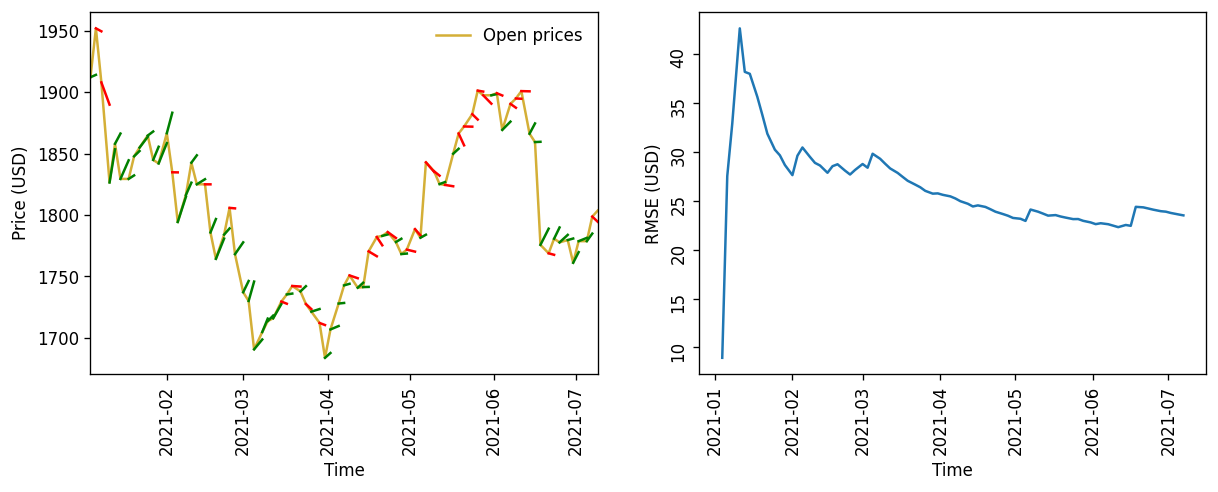

In [25]:
test_prices_sarimax_ag=yl.display_best_sarimax_model(y_train, y_test, sarimax_params, exogenous=True,
                                                 exogenous_list=[ag[['open']]])

#### 3.2.2 SARIMAX Models with All Selected Exogenous Variables

In [59]:
with open('task06092021_SARIMAX_with_Exogenous.pkl', 'rb') as file:
    results=pickle.load(file)
    test_results=pickle.load(file)
test_results.head()

,params,train mean accuracy,test RMSE,test accuracy
24,"(2, 3, 1, 2, 1, 1, 20)",0.560145,43.617608,0.651515
1,"(1, 3, 1, 3, 1, 0, 5)",0.611957,56.092215,0.621212
43,"(2, 1, 1, 0, 0, 3, 15)",0.550000,22.936902,0.590909
19,"(3, 1, 2, 1, 0, 2, 7)",0.567029,22.960428,0.590909
8,"(2, 1, 1, 1, 1, 0, 15)",0.584420,29.686513,0.590909


Prediction accuracy is 63.75%
-----------------------------------------------------------------------
       True Positive  False Negative  False Positive  True Negative
Count             29              13              16             22
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.58      0.60        38
           1       0.64      0.69      0.67        42

    accuracy                           0.64        80
   macro avg       0.64      0.63      0.63        80
weighted avg       0.64      0.64      0.64        80

-----------------------------------------------------------------------


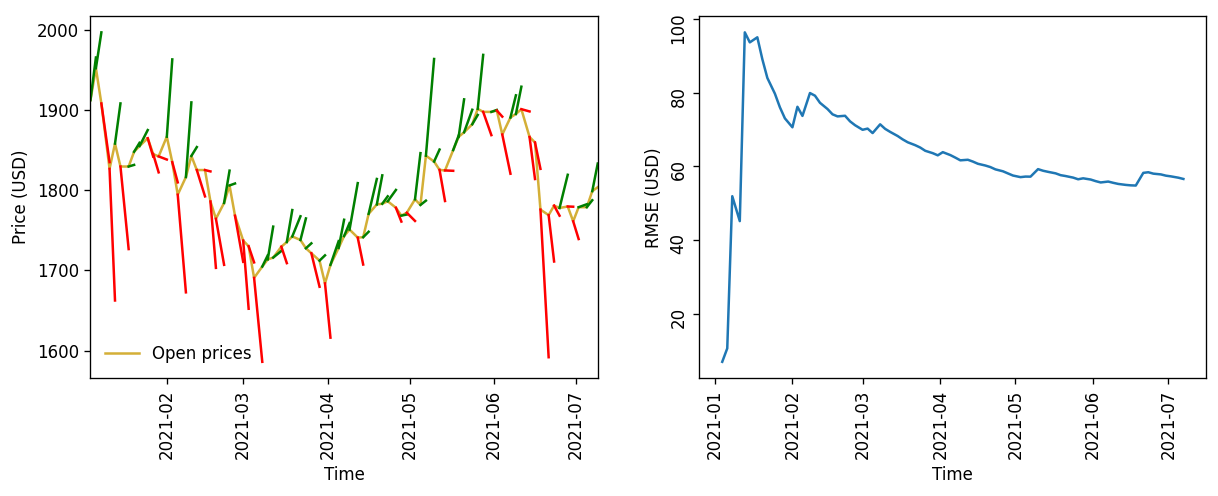

In [26]:
sarimax_params=(1, 3, 1, 3, 1, 0, 5)
test_prices_sarimax_all=yl.display_best_sarimax_model(y_train, y_test, sarimax_params, exogenous=True,
                                                 exogenous_list=exogenous_list)

## 4. Determination of Model Profit

The most important criterion of the model is how much money it can make. Here I am going to make the investment with the help of Kelly Criterion. A dummy approach is that, I decide to buy or sell gold from comparing today's and yesterday's open prices without using the model at all. Next I am using the four models to see how much improvement I can get.

### 4.1 A Dummy Approach

In [27]:
##################################################################
# Test data: from Jan 2021 to present
##################################################################
# Fill in yesterday's open prices
##################################################################
for price in test_prices_sarimax_baseline.golds:
    price.open_price_yesterday=Y.loc[price.datetime_yesterday, 'open']
########################################
kelly_fs=np.linspace(start=0, stop=1, num=500, endpoint=True)
incomes=pd.DataFrame(columns=['Kelly F', 'Money'])
selected_prices=[ele for ele in test_prices_sarimax_baseline.golds if ele.datetime>=pd.to_datetime("2021", format="%Y")]
for kelly_f in kelly_fs:
    money=10000
    share=0.0
    for price in selected_prices:
        if share<0.01 and price.open_price>price.open_price_yesterday:
            share=money*kelly_f/price.open_price
            money=money-money*kelly_f
        elif share>0.01 and price.open_price<price.open_price_yesterday:
            money=money+share*price.open_price
            share=0.0
        else:
            pass
    money=money+share*selected_prices[-1].open_price
    incomes=incomes.append(pd.DataFrame({'Kelly F': [kelly_f], 'Money': [money]}))
###############################################
incomes.sort_values('Money', ascending=False).head()

,Kelly F,Money
0,1.000000,10118.718769
0,0.997996,10118.515663
0,0.995992,10118.312416
0,0.993988,10118.109028
0,0.991984,10117.905499


I can see that in the dummy approach, the profit is about 7.5% annual yeild.

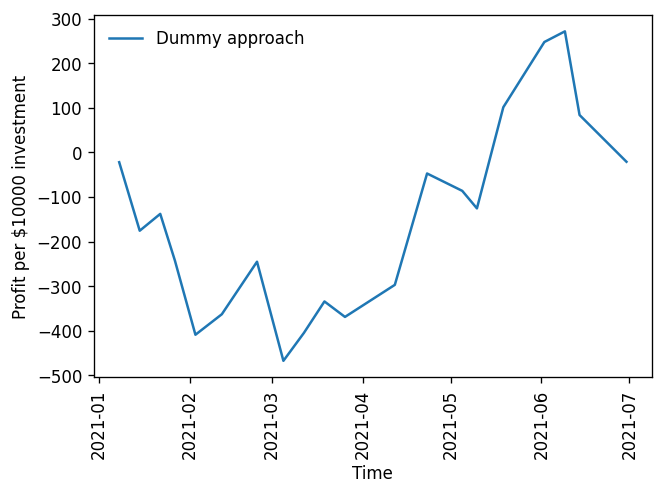

In [28]:
############################################
# Plot the income if all-in
############################################
kelly_f=1.0
money=10000
share=0.0
dummy_income_I=pd.DataFrame(columns=['Money'])
selected_prices=[ele for ele in test_prices_sarimax_baseline.golds if ele.datetime>=pd.to_datetime("2020-07", format="%Y-%m")]
for price in selected_prices:
    if share<0.01 and price.open_price>price.open_price_yesterday:
        share=money*kelly_f/price.open_price
        money=money-money*kelly_f
    elif share>0.01 and price.open_price<price.open_price_yesterday:
        money=money+share*price.open_price
        share=0.0
        dummy_income_I=dummy_income_I.append(pd.DataFrame({'Money': [money-10000]}, index=[price.datetime]))
    else:
        pass
_=plt.plot(dummy_income_I, label='Dummy approach')
_=plt.legend(frameon=False)
_=plt.xticks(rotation=90)
_=plt.xlabel('Time')
_=plt.ylabel('Profit per $10000 investment')
plt.show()

### 4.2 Comparison of SARIMAX Models to Dummy

#### 4.2.1 SARIMAX without Exogenous Variables

In [29]:
test_prices_sarimax_baseline.income().head()

,Kelly F,Money
0,1.000000,11031.807144
0,0.997996,11029.674141
0,0.995992,11027.541401
0,0.993988,11025.408924
0,0.991984,11023.276711


In [50]:
test_prices_sarimax_baseline.RMSE()

62.03248573926978

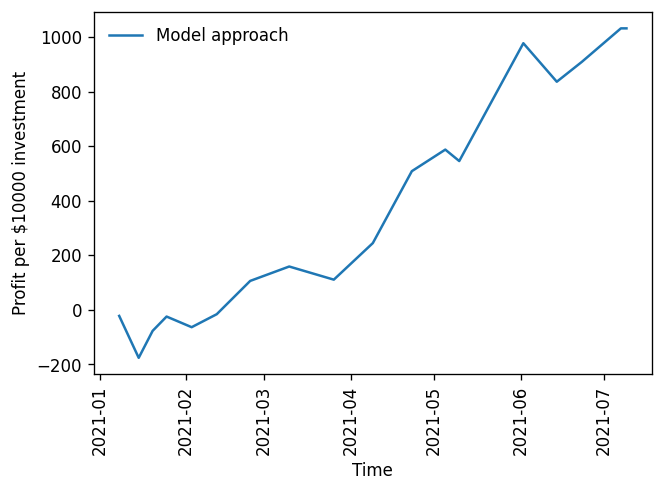

In [31]:
_=test_prices_sarimax_baseline.income_plot()

#### 4.2.2 SARIMAX with Ag prices

In [32]:
test_prices_sarimax_ag.income().head()

,Kelly F,Money
0,1.000000,11018.610552
0,0.997996,11016.556800
0,0.995992,11014.503075
0,0.993988,11012.449380
0,0.991984,11010.395713


In [33]:
test_prices_sarimax_ag.RMSE()

23.372435730361147

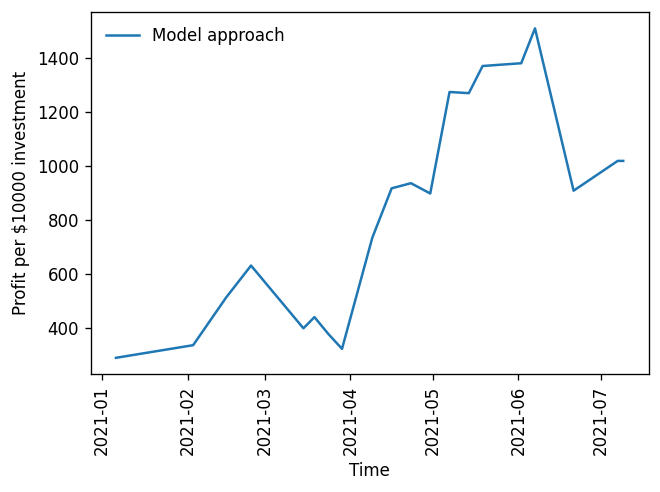

In [34]:
_=test_prices_sarimax_ag.income_plot()

#### 4.2.3 SARIMAX with All Selected Exogenous Variables

In [51]:
test_prices_sarimax_all.income().head()

,Kelly F,Money
0,1.000000,10912.516891
0,0.997996,10910.647619
0,0.995992,10908.778507
0,0.993988,10906.909555
0,0.991984,10905.040763


In [52]:
test_prices_sarimax_all.RMSE()

56.320184553326015

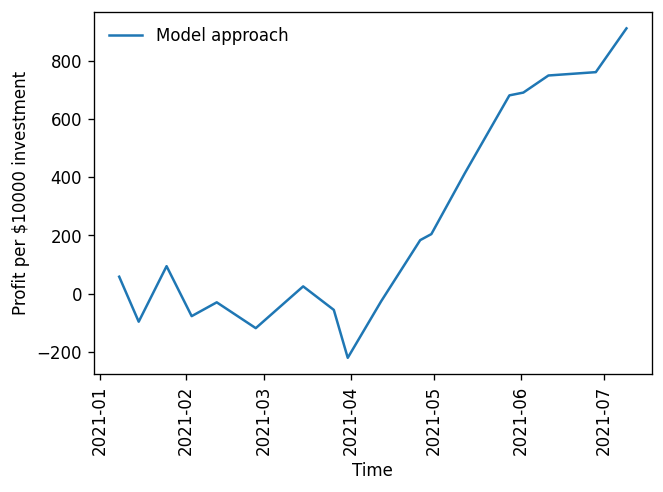

In [37]:
_=test_prices_sarimax_all.income_plot()

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


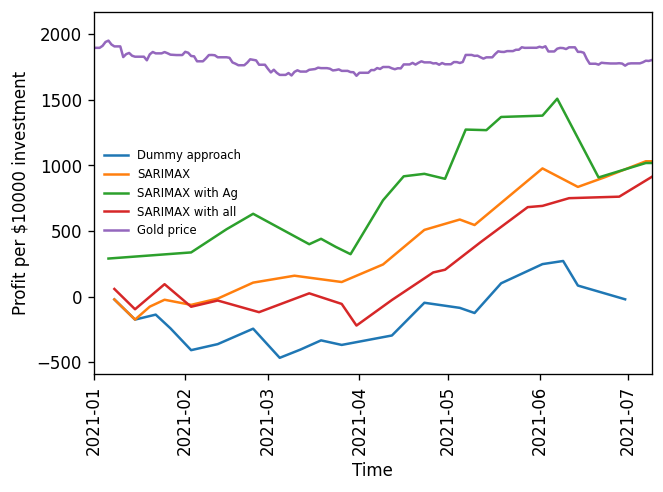

In [49]:
####################################
# Plot the income
####################################
_=plt.plot(dummy_income_I, label='Dummy approach')
#########################################################
kelly_f=1.0
money=10000
share=0.0
model_income=pd.DataFrame(columns=['Money'])
selected_prices=[ele for ele in test_prices_sarimax_baseline.golds if ele.datetime>=pd.to_datetime("2021", format="%Y")]
for price in selected_prices:
    if share<0.01 and price.open_price<price.predicted_open_price:
        share=money*kelly_f/price.open_price
        money=money-money*kelly_f
    elif share>0.01 and price.open_price>price.predicted_open_price:
        money=money+share*price.open_price
        share=0.0
        model_income=model_income.append(pd.DataFrame({'Money': [money-10000]}, index=[price.datetime]))
    else:
        pass
money=money+share*selected_prices[-1].open_price
share=0.0
model_income=model_income.append(pd.DataFrame({'Money': [money-10000]}, index=[selected_prices[-1].datetime]))
_=plt.plot(model_income, label='SARIMAX')
##################################################################
kelly_f=1.0
money=10000
share=0.0
model_income=pd.DataFrame(columns=['Money'])
selected_prices=[ele for ele in test_prices_sarimax_ag.golds if ele.datetime>=pd.to_datetime("2021", format="%Y")]
for price in selected_prices:
    if share<0.01 and price.open_price<price.predicted_open_price:
        share=money*kelly_f/price.open_price
        money=money-money*kelly_f
    elif share>0.01 and price.open_price>price.predicted_open_price:
        money=money+share*price.open_price
        share=0.0
        model_income=model_income.append(pd.DataFrame({'Money': [money-10000]}, index=[price.datetime]))
    else:
        pass
money=money+share*selected_prices[-1].open_price
share=0.0
model_income=model_income.append(pd.DataFrame({'Money': [money-10000]}, index=[selected_prices[-1].datetime]))
_=plt.plot(model_income, label='SARIMAX with Ag')
##################################################################
kelly_f=1.0
money=10000
share=0.0
model_income=pd.DataFrame(columns=['Money'])
selected_prices=[ele for ele in test_prices_sarimax_all.golds if ele.datetime>=pd.to_datetime("2021", format="%Y")]
for price in selected_prices:
    if share<0.01 and price.open_price<price.predicted_open_price:
        share=money*kelly_f/price.open_price
        money=money-money*kelly_f
    elif share>0.01 and price.open_price>price.predicted_open_price:
        money=money+share*price.open_price
        share=0.0
        model_income=model_income.append(pd.DataFrame({'Money': [money-10000]}, index=[price.datetime]))
    else:
        pass
money=money+share*selected_prices[-1].open_price
share=0.0
model_income=model_income.append(pd.DataFrame({'Money': [money-10000]}, index=[selected_prices[-1].datetime]))
_=plt.plot(model_income, label='SARIMAX with all')
##################################################################
_=plt.plot(Y, label='Gold price')
_=plt.legend(frameon=False, loc='best', prop={'size': 7})
_=plt.xticks(rotation=90)
_=plt.xlim([pd.to_datetime("2021", format="%Y"), Y.index[-1]])
_=plt.xlabel('Time')
_=plt.ylabel('Profit per $10000 investment')
plt.show()

In [44]:
###################################
# The latest prediction
###################################
test_prices_sarimax_ag.prediction_report()

,Current price ($),Predicted price ($)
2021-07-09,1803.60,N/A
2021-07-12,N/A,1802.77


## 5. Conclusion

The most important findings of this project is that, the prices of silver has significant prediction power for gold prices, while other exogenous variables have less prediction power. Also, the SARIMAX model is good enough for the gold price prediction. 

However, the SARIMAX model with Ag prices as exogenous variables failed to predict the big drop of gold prices in the middle of June 2021, making the final performance (profit) less attractive. If I can ignore this failure, the SARIMAX model with Ag prices is actually out-performed than other models. The baseline SARIMAX model without any exogenous variables and the SARIMAX model with many exogenous variables exhibit similar performance, which is about 20% annual yield.

In this work, I used a Monday-Wednesday-Friday prediction pattern. In the future work, I am going to make more aggresive approaches such as multiple predictions per day or even within several minutes, to further improve the profit of the model. Also I consider using recursive neural networks such as long short-term memory (LSTM) to make the prediction.

### References
[1] Aihui Ong, Is Gold a Good Investment? Gold Price Prediction Using Machine Learning Techniques. https://www.springboard.com/blog/gold-price-prediction-using-machine-learning, 2020.

[2] Bhanu Yerra, Predicting Tomorrows Gold Price. Do We Have a Market Advantage? https://mlbhanuyerra.github.io/2019-10-12-Predicting-Tomorrows-Gold-Price/, 2019.

[3] ur Sami, I., and Khurum Nazir Junejo. Predicting Future Gold Rates using Machine Learning Approach. International Journal of Advanced Computer Science and Applications 8, no. 12: 92-99, 2017.

[4] Potoski, Megan. Predicting gold prices. CS229, Autumn, 2013.

[5] Ishan Shah, and Rekhit Pachanekar, Gold Price Prediction Using Machine Learning In Python. https://blog.quantinsti.com/gold-price-prediction-using-machine-learning-python/, 2020  

[6] Bingol, Sakir, Safaa Sadik, Raland Matenggo, Hatim Badr Mouhcine, Jihad Albaf, Salma Chaabene, and Aaron Auta. Gold price prediction in times of 4inancial and geopolitical uncertainty: A machine learning approach. 2020.

[7] Zhu, Han-chao, and Wang, Dong. Predict the price of gold Based on Machine Learning Techniques. DEStech Transactions on Computer Science and Engineering mmsta, 2017.

[8] https://finance.yahoo.com

[9] Box, George EP, Gwilym M. Jenkins, Gregory C. Reinsel, and Greta M. Ljung. Time series analysis: forecasting and control. John Wiley & Sons, 2015.

[10] Ariyo, Adebiyi A., Adewumi O. Adewumi, and Charles K. Ayo. "Stock price prediction using the ARIMA model." In 2014 UKSim-AMSS 16th International Conference on Computer Modelling and Simulation, pp. 106-112. IEEE, 2014.

[11] https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56

